In [2]:
%%capture
!pip install transformers datasets prettytable

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset
from prettytable import PrettyTable

from tqdm import tqdm
from transformers import BertTokenizer

import matplotlib.pyplot as plt

plt.style.use('default')
plt.rc('text', usetex=True) # Turn this False if you don't want to use LaTeX for text rendering
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

In [4]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Users/quyenlinhta/PycharmProjects/llm-iasd/llm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
def preprocessing_fn(data, tokenizer):
    tokenized_output = tokenizer(
        data["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False
    )
    data["review_ids"] = tokenized_output["input_ids"]
    data["label"] = [0 if sentiment == "negative" else 1 for sentiment in data["sentiment"]]
    return data

In [7]:
n_samples = 50000
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(n_samples))
tokenized_dataset = dataset.map(lambda x: preprocessing_fn(x, tokenizer), batched=True)
tokenized_dataset.set_format(type='torch', columns=['review_ids', 'label'])
document_train_set, document_valid_set = tokenized_dataset.train_test_split(test_size=0.2).values()

In [8]:
table = PrettyTable()
table.field_names = ["Dataset", "Size", "Number of classes"]
table.add_row(["Train", len(document_train_set), len(document_train_set.unique("label"))])
table.add_row(["Validation", len(document_valid_set), len(document_valid_set.unique("label"))])
print(table)

Flattening the indices:   0%|          | 0/40000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/10000 [00:00<?, ? examples/s]

+------------+-------+-------------------+
|  Dataset   |  Size | Number of classes |
+------------+-------+-------------------+
|   Train    | 40000 |         2         |
| Validation | 10000 |         2         |
+------------+-------+-------------------+


In [9]:
print(document_train_set.column_names)

['review', 'sentiment', 'review_ids', 'label']


In [10]:
def extract_words_contexts(document_ids, radius):
    if len(document_ids) == 0:
        return torch.empty(0), torch.empty(0, 2 * radius)
    if not isinstance(document_ids, torch.Tensor):
        document_ids = torch.tensor(document_ids)
    padding_token = -1
    padded_document_ids = torch.cat(
        [torch.full((radius,), padding_token), document_ids, torch.full((radius,), padding_token)])
    contexts = [
        torch.cat([
            padded_document_ids[i:i + radius],
            padded_document_ids[i + radius + 1:i + 2 * radius + 1]
        ])
        for i in range(radius, len(document_ids) + radius)
    ]
    contexts = torch.stack(
        [c if len(c) == 2 * radius else torch.cat([c, torch.full((2 * radius - len(c),), padding_token)]) for c in
         contexts])
    return document_ids, contexts


def flatten_dataset_to_list(dataset, radius):
    aggregated_word_ids, aggregated_contexts, aggregated_labels = [], [], []
    for document in dataset:
        word_ids, contexts = extract_words_contexts(document['review_ids'], radius)
        aggregated_word_ids.extend(word_ids.tolist())
        aggregated_contexts.extend(contexts.tolist())
        aggregated_labels.extend([document['label']] * len(word_ids))
    return aggregated_word_ids, aggregated_contexts, aggregated_labels

In [11]:
radius = 5
train_word_ids, train_contexts, train_labels = flatten_dataset_to_list(document_train_set, radius)
valid_word_ids, valid_contexts, valid_labels = flatten_dataset_to_list(document_valid_set, radius)

table = PrettyTable()
table.field_names = ["IDs", "Contexts", "Labels"]
table.add_row([len(train_word_ids), len(train_contexts), len(train_labels)])
table.add_row([len(valid_word_ids), len(valid_contexts), len(valid_labels)])
print(table)

+---------+----------+---------+
|   IDs   | Contexts |  Labels |
+---------+----------+---------+
| 8243234 | 8243234  | 8243234 |
| 2052488 | 2052488  | 2052488 |
+---------+----------+---------+


In [12]:
class WordContextDataset(torch.utils.data.Dataset):
    def __init__(self, word_ids, contexts, labels):
        assert len(word_ids) == len(contexts) == len(labels), "Length of word_ids, contexts, and labels must be the same"
        self.word_ids = torch.tensor(word_ids, dtype=torch.long)
        self.contexts = torch.tensor(contexts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.word_ids)

    def __getitem__(self, idx):
        return {
            'word_id': self.word_ids[idx],
            'context': self.contexts[idx],
            'label': self.labels[idx]
        }

In [13]:
train_set = WordContextDataset(train_word_ids, train_contexts, train_labels)
valid_set = WordContextDataset(valid_word_ids, valid_contexts, valid_labels)

In [14]:
table = PrettyTable()
table.field_names = ["Dataset", "Size", "Number of classes"]
table.add_row(["Train", len(train_set), torch.unique(train_set.labels).shape[0]])
table.add_row(["Validation", len(valid_set), torch.unique(valid_set.labels).shape[0]])
print(table)

+------------+---------+-------------------+
|  Dataset   |   Size  | Number of classes |
+------------+---------+-------------------+
|   Train    | 8243234 |         2         |
| Validation | 2052488 |         2         |
+------------+---------+-------------------+


In [15]:
def collate_fn(batch, vocabulary_size, K, R):
    word_ids = torch.stack([item['word_id'] for item in batch])
    contexts = torch.stack([item['context'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    negative_contexts = torch.randint(low=0, high=vocabulary_size, size=(len(batch), 2 * K * R))
    return {
        'word_id': word_ids,
        'positive_context_ids': contexts,
        'negative_context_ids': negative_contexts,
        'labels': labels
    }

In [16]:
vocabulary_size = len(tokenizer.get_vocab())
batch_size = 128
K, R = 5, 5

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocabulary_size, K, R))
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, vocabulary_size, K, R))

In [17]:
train_loader.dataset[0], train_loader.dataset[1], train_loader.dataset[2]

({'word_id': tensor(2106),
  'context': tensor([ 2106, 21372, 27687,  2428,  2156,  3185,  1029,  1037,  2307,  4234]),
  'label': tensor(0)},
 {'word_id': tensor(21372),
  'context': tensor([21372, 27687,  2428,  2156,  2023,  1029,  1037,  2307,  4234,  3185]),
  'label': tensor(0)},
 {'word_id': tensor(27687),
  'context': tensor([27687,  2428,  2156,  2023,  3185,  1037,  2307,  4234,  3185,  1029]),
  'label': tensor(0)})

In [18]:
table = PrettyTable()
for i, batch in enumerate(train_loader):
    table.field_names = ["Batch", "Word ID", "Positive Contexts", "Negative Contexts", "Labels"]
    table.add_row([i, batch['word_id'].shape, batch['positive_context_ids'].shape, batch['negative_context_ids'].shape, batch['labels'].shape])
    if i == 2:
        break
print(table)

+-------+-------------------+-----------------------+-----------------------+-------------------+
| Batch |      Word ID      |   Positive Contexts   |   Negative Contexts   |       Labels      |
+-------+-------------------+-----------------------+-----------------------+-------------------+
|   0   | torch.Size([128]) | torch.Size([128, 10]) | torch.Size([128, 50]) | torch.Size([128]) |
|   1   | torch.Size([128]) | torch.Size([128, 10]) | torch.Size([128, 50]) | torch.Size([128]) |
|   2   | torch.Size([128]) | torch.Size([128, 10]) | torch.Size([128, 50]) | torch.Size([128]) |
+-------+-------------------+-----------------------+-----------------------+-------------------+


In [19]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, word_ids, context_ids, negative_context_ids):
        target_embeds = self.target_embeddings(word_ids)
        context_embeds = self.context_embeddings(context_ids)
        negative_context_embeds = self.context_embeddings(negative_context_ids)
        positive_dot = torch.bmm(context_embeds, target_embeds.unsqueeze(2)).squeeze(2)
        positive_scores = torch.sigmoid(positive_dot)
        negative_dot = torch.bmm(negative_context_embeds, target_embeds.unsqueeze(2)).squeeze(2)
        negative_scores = torch.sigmoid(negative_dot)
        return positive_scores, negative_scores

    def compute_loss(self, positive_scores, negative_scores):
        positive_labels = torch.ones_like(positive_scores)
        negative_labels = torch.zeros_like(negative_scores)
        positive_loss = F.binary_cross_entropy(positive_scores, positive_labels)
        negative_loss = F.binary_cross_entropy(negative_scores, negative_labels)
        return positive_loss + negative_loss

In [20]:
def train_model(model, train_loader, valid_loader, optimizer, epochs, device):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    validation_losses = []
    validation_accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit='batch')
        for batch in progress_bar:
            optimizer.zero_grad()
            positive_scores, negative_scores = model(
                batch['word_id'].to(device),
                batch['positive_context_ids'].to(device),
                batch['negative_context_ids'].to(device)
            )
            loss = model.compute_loss(positive_scores, negative_scores)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct_positives = (positive_scores > 0.5).float().sum()
            correct_negatives = (negative_scores < 0.5).float().sum()
            total_correct += correct_positives.item() + correct_negatives.item()
            total_samples += positive_scores.numel() + negative_scores.numel()
            progress_bar.set_postfix(loss="{:.4f}".format(loss.item()))
        progress_bar.close()

        average_train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_samples
        epoch_losses.append(average_train_loss)
        epoch_accuracies.append(train_accuracy)

        validation_loss, validation_accuracy = validate_model(model, valid_loader, device)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(f"Epoch {epoch + 1}: Train Loss = {average_train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Validation Loss = {validation_loss:.4f}, Validation Accuracy = {validation_accuracy:.4f}")

    return epoch_losses, epoch_accuracies, validation_losses, validation_accuracies

def validate_model(model, valid_loader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    progress_bar = tqdm(valid_loader, desc="Validation", unit='batch')
    with torch.no_grad():
        for batch in progress_bar:
            positive_scores, negative_scores = model(
                batch['word_id'].to(device),
                batch['positive_context_ids'].to(device),
                batch['negative_context_ids'].to(device)
            )
            loss = model.compute_loss(positive_scores, negative_scores)
            total_loss += loss.item()
            correct_positives = (positive_scores > 0.5).float().sum()
            correct_negatives = (negative_scores < 0.5).float().sum()
            total_correct += correct_positives.item() + correct_negatives.item()
            total_samples += positive_scores.numel() + negative_scores.numel()
            progress_bar.set_postfix(loss="{:.4f}".format(loss.item()))
    progress_bar.close()
    average_loss = total_loss / len(valid_loader)
    accuracy = total_correct / total_samples
    return average_loss, accuracy

In [21]:
model_dim = 128
batch_size = 256
epochs = 5

In [22]:
vocab_size = len(tokenizer.get_vocab())
model = Word2Vec(vocab_size, embedding_dim=model_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("mps")
model.to(device)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab_size, K, R))
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_size, K, R))

train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, optimizer, epochs, device)

Validation: 100%|██████████| 8018/8018 [00:53<00:00, 150.02batch/s, loss=0.4834]


Epoch 1: Train Loss = 1.7382, Train Accuracy = 0.8539, Validation Loss = 0.6383, Validation Accuracy = 0.9027


Validation: 100%|██████████| 8018/8018 [00:49<00:00, 162.77batch/s, loss=0.3897]


Epoch 2: Train Loss = 0.5423, Train Accuracy = 0.9079, Validation Loss = 0.5185, Validation Accuracy = 0.9102


Validation: 100%|██████████| 8018/8018 [00:44<00:00, 179.42batch/s, loss=0.3775]


Epoch 3: Train Loss = 0.4756, Train Accuracy = 0.9126, Validation Loss = 0.4923, Validation Accuracy = 0.9129


Validation: 100%|██████████| 8018/8018 [00:49<00:00, 162.14batch/s, loss=0.3850]


Epoch 4: Train Loss = 0.4547, Train Accuracy = 0.9146, Validation Loss = 0.4839, Validation Accuracy = 0.9140


Validation: 100%|██████████| 8018/8018 [00:38<00:00, 206.57batch/s, loss=0.3838]

Epoch 5: Train Loss = 0.4448, Train Accuracy = 0.9156, Validation Loss = 0.4809, Validation Accuracy = 0.9148


In [23]:
table = PrettyTable()
table.field_names = ["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]
for i in range(epochs):
    table.add_row([i + 1, round(train_losses[i], 4), round(train_accuracies[i], 4), round(valid_losses[i], 4), round(valid_accuracies[i], 4)])
print(table)

+-------+------------+----------------+-----------------+---------------------+
| Epoch | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
+-------+------------+----------------+-----------------+---------------------+
|   1   |   1.7382   |     0.8539     |      0.6383     |        0.9027       |
|   2   |   0.5423   |     0.9079     |      0.5185     |        0.9102       |
|   3   |   0.4756   |     0.9126     |      0.4923     |        0.9129       |
|   4   |   0.4547   |     0.9146     |      0.4839     |        0.914        |
|   5   |   0.4448   |     0.9156     |      0.4809     |        0.9148       |
+-------+------------+----------------+-----------------+---------------------+


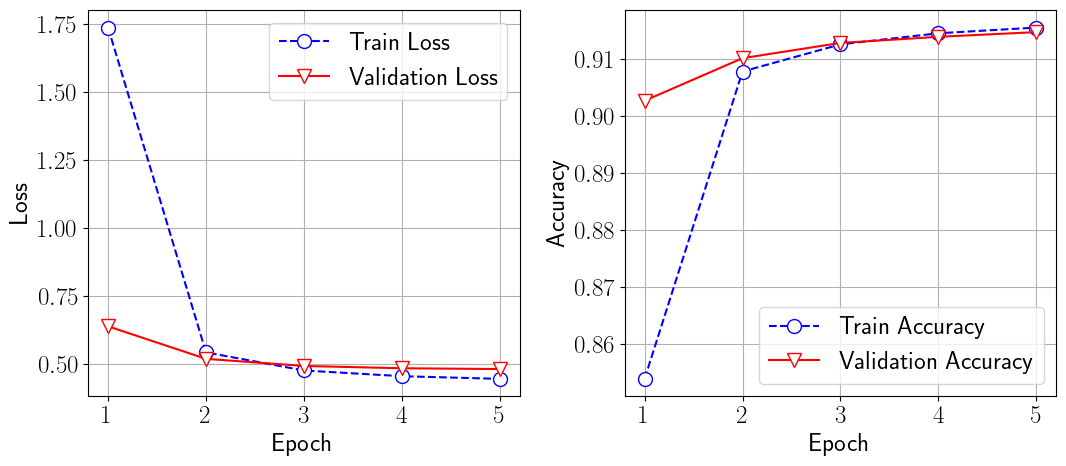

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
marker = ["o", "v"]
color = ["blue", "red"]
linestyle = ["--", "-"]
markerfacecolor = ["white", "white"]
markersize = 10
grid = True
ax[0].plot(range(1, epochs + 1), train_losses, label="Train Loss", marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[0].plot(range(1, epochs + 1), valid_losses, label="Validation Loss", marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(grid)

ax[1].plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[1].plot(range(1, epochs + 1), valid_accuracies, label="Validation Accuracy", marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(grid)

plt.tight_layout()
plt.show()

In [25]:
def get_word_embedding(model, word, tokenizer, device):
    word_id = torch.tensor(tokenizer.convert_tokens_to_ids(word), dtype=torch.long).to(device)
    word_embedding = model.target_embeddings(word_id)
    return word_embedding

def get_similar_words(model, word, tokenizer, device, top_k=10):
    word_embedding = get_word_embedding(model, word, tokenizer, device)
    context_embeddings = model.context_embeddings.weight
    similarities = torch.cosine_similarity(word_embedding, context_embeddings, dim=1)
    top_similarities, top_indices = torch.topk(similarities, top_k)
    top_words = [tokenizer.convert_ids_to_tokens([idx.item()])[0] for idx in top_indices]
    return top_words, top_similarities

In [26]:
word = "bad"
top_words, top_similarities = get_similar_words(model, word, tokenizer, device)
table = PrettyTable()
table.field_names = ["Word", "Similarity"]
for w, s in zip(top_words, top_similarities):
    table.add_row([w, round(s.item(), 4)])
print(table)

+----------+------------+
|   Word   | Similarity |
+----------+------------+
|   bad    |   0.6539   |
|  awful   |   0.6353   |
| horrible |   0.6205   |
| terrible |   0.6115   |
|  stupid  |   0.6088   |
|  worse   |   0.5984   |
|  acting  |   0.593    |
|   mean   |   0.589    |
|  script  |   0.5682   |
|   guys   |   0.5625   |
+----------+------------+


In [27]:
def save_model(model, model_dim, radius, k_ratio, batch_size, epochs):
    filename = f"model_dim-{model_dim}_radius-{radius}_ratio-{k_ratio}-batch-{batch_size}-epoch-{epochs}.ckpt"
    torch.save({
        'target_embeddings': model.target_embeddings.weight.data.cpu(),
        'context_embeddings': model.context_embeddings.weight.data.cpu()
    }, filename)
    return filename

In [28]:
save_model(model, model_dim, R, K, batch_size, epochs)

'model_dim-128_radius-5_ratio-5-batch-256-epoch-5.ckpt'